<h1>Autoencoders

<h2>Importing required libraries

In [1]:
import torch
import random
import numpy as np
import torch.nn as nn
import tensorflow as tf
import torch.distributions
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from keras.datasets import fashion_mnist

<h2>Initializing device details and Importing the dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

<h2>Displaying sample images from dataset

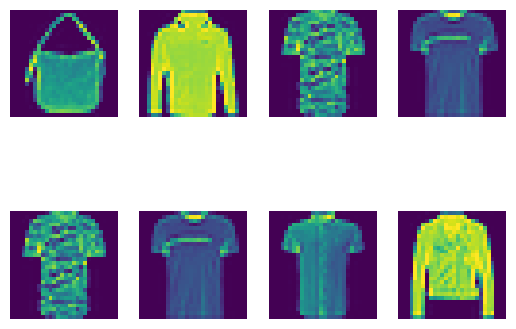

In [3]:
def displayImages(imageList, rows, columns):
    fig, grid = plt.subplots(rows,columns) 
    for i in range(rows):
        for j in range(columns):
            grid[i,j].axis('off')
            grid[i,j].imshow(np.reshape(imageList[(i-1)*rows+j], (28,28)))

numSamples = 8
randomIndices = random.sample(range(0, len(xTrain)), numSamples)
displayImages(list(np.array(xTrain)[randomIndices]), 2, 4)

<h2>Dataset Preprocessing

In [4]:
length, breadth = xTrain[0].shape
flattenDim = length * breadth
#xTrain = torch.FloatTensor(np.round(xTrain / 27).astype(int)).to(device)
xTrain = np.round(xTrain / 27).astype(int)
xTest = np.round(xTest / 27).astype(int)
xTrainFlat = torch.FloatTensor(np.reshape(xTrain, (-1,flattenDim))).to(device)
xTestFlat = np.reshape(xTest, (-1,flattenDim)) 

<h2>Initializing TrainLoader and TestLoader functions

In [5]:
trainLoader = DataLoader(dataset = xTrainFlat, batch_size = 32, shuffle = True)
testLoader = DataLoader(dataset = xTestFlat, batch_size = 16, shuffle = True)

<h2>Defining Variational AutoEncoder class

In [6]:
latentSize = 100

class variationalAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * latentSize)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latentSize, 2 * latentSize),
            nn.ReLU(),
            nn.Linear(2 * latentSize, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784)
        )
    def reparameterization(self, mean, logVariance):
        standardDeviation = torch.exp(0.5 * logVariance)
        epsilonValue = torch.randn_like(standardDeviation)
        chosenSample = mean + (epsilonValue * standardDeviation)
        return chosenSample

    def forward(self, x):
        encoded = self.encoder(x)
        mean, logVariance = torch.split(encoded, latentSize, dim = 2)
        z = self.reparameterization(mean, logVariance)
        reconstructed = self.decoder(z)
        return mean, logVariance, reconstructed

<h2>Training the AutoEncoder model

In [7]:
vaeModel = variationalAE().to(device)
vaeModel.load_state_dict(torch.load("vae.pth"))
vaeModel.eval()

variationalAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=200, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=784, bias=True)
  )
)

<h2>Binary Classifier

In [8]:
class BinaryClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = latentSize, out_features = 40)
        self.layer2 = nn.Linear(in_features = 40, out_features = 30)
        self.layer3 = nn.Linear(in_features = 30, out_features = 20)
        self.layer4 = nn.Linear(in_features = 20, out_features = 10)
        self.layer5 = nn.Linear(in_features = 10, out_features = 1)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = F.relu(x)
        x = self.layer5(x)
        x = self.activation(x)
        return x

In [9]:
z = vaeModel.encoder(xTrainFlat)
infMean, infLogVariance = torch.split(z, latentSize, dim = 1)

qzx = vaeModel.reparameterization(infMean, infLogVariance)
pzx = torch.randn((len(xTrain), latentSize), device = device)

qzxLabel = torch.ones((len(xTrain), 1)).to(device)
pzxLabel = torch.zeros((len(xTrain), 1)).to(device)

trainLabels = torch.cat((qzxLabel, pzxLabel)).to(device)
trainData = torch.cat((qzx, pzx)).to(device)

In [10]:
class customDataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.transform = transform
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        return image, label

In [11]:
trainDataset = customDataset(data = trainData, labels = trainLabels)
binaryTrainLoader = DataLoader(dataset = trainDataset, batch_size = 100, shuffle = True)

In [12]:
bcModel = BinaryClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(bcModel.parameters(), lr = (1e-2), momentum=0.8)

lowestEpochLoss = []
averageEpochLoss = []
epochList = np.arange(0, 25, dtype = int)

encoderOutputs = []
decoderOutputs = []
for epoch in range(25):
  losses = []
  for batchIndex, (batchImage, batchLabels) in enumerate(binaryTrainLoader):
    batchImage = batchImage.to(device)
    batchLabels = batchLabels.to(device)
    predictedOutput  = bcModel(batchImage)
    loss = criterion(predictedOutput, batchLabels)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.cpu().detach().numpy())
  print("Epoch: ",epoch,"| Average loss: ",np.round(np.average(losses), 2),"| Lowest Loss: ",np.round(np.amin(losses), 2))
  lowestEpochLoss.append(np.amin(losses))
  averageEpochLoss.append(np.average(losses))
  #torch.save(bcModel.state_dict(), "bc.pth")

Epoch:  0 | Average loss:  0.69 | Lowest Loss:  0.69
Epoch:  1 | Average loss:  0.69 | Lowest Loss:  0.69
Epoch:  2 | Average loss:  0.69 | Lowest Loss:  0.68
Epoch:  3 | Average loss:  0.68 | Lowest Loss:  0.63
Epoch:  4 | Average loss:  0.63 | Lowest Loss:  0.52
Epoch:  5 | Average loss:  0.6 | Lowest Loss:  0.48
Epoch:  6 | Average loss:  0.59 | Lowest Loss:  0.47
Epoch:  7 | Average loss:  0.58 | Lowest Loss:  0.45
Epoch:  8 | Average loss:  0.58 | Lowest Loss:  0.45
Epoch:  9 | Average loss:  0.57 | Lowest Loss:  0.42
Epoch:  10 | Average loss:  0.57 | Lowest Loss:  0.43
Epoch:  11 | Average loss:  0.56 | Lowest Loss:  0.42
Epoch:  12 | Average loss:  0.56 | Lowest Loss:  0.41
Epoch:  13 | Average loss:  0.56 | Lowest Loss:  0.43
Epoch:  14 | Average loss:  0.56 | Lowest Loss:  0.43
Epoch:  15 | Average loss:  0.55 | Lowest Loss:  0.42
Epoch:  16 | Average loss:  0.55 | Lowest Loss:  0.42
Epoch:  17 | Average loss:  0.55 | Lowest Loss:  0.42
Epoch:  18 | Average loss:  0.55 | Lowe

In [18]:
torch.save(bcModel.state_dict(), "bc.pth")

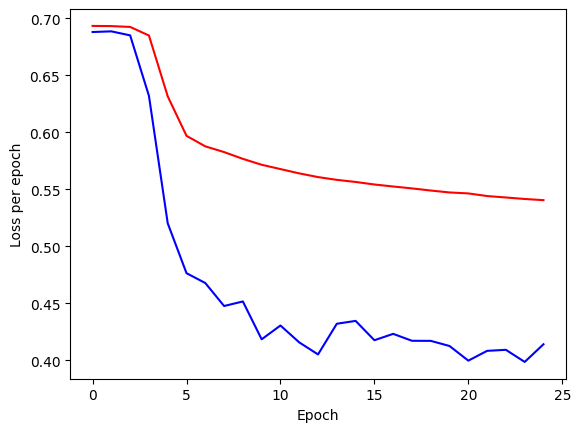

In [13]:
plt.plot(epochList, lowestEpochLoss, color = 'blue', label = 'Lowest loss')
plt.plot(epochList, averageEpochLoss, color = 'red', label = 'Average loss')
plt.xlabel('Epoch')
plt.ylabel('Loss per epoch')
plt.show()

In [21]:
bcModel.eval()
bcModel(torch.rand((1, latentSize), device=device)).item()

0.40462368726730347

In [19]:
bcModel.eval()
randomIndices = random.sample(range(0, len(xTest)), 1)
bcModel(trainData[randomIndices]).item()

0.8366165161132812

In [105]:
z0 = torch.randn(latentSize, device = device, requires_grad = True)
stepSize = 1e-2
normalMean = torch.tensor([0.0], device = device)
normalSTD = torch.tensor([1.0], device = device)
for timeStamp in range(1000):
    dZ = bcModel(z0)
    rZ = dZ / (1 - dZ)
    energyFunction = (-torch.log(rZ) - torch.distributions.Normal(normalMean, normalSTD).log_prob(z0).to(device))
    z0 = z0 - (0.5 * stepSize * torch.autograd.grad(energyFunction.mean(), z0)[0]) + (torch.sqrt(torch.tensor(stepSize)) * torch.randn((1,1), device = device))  

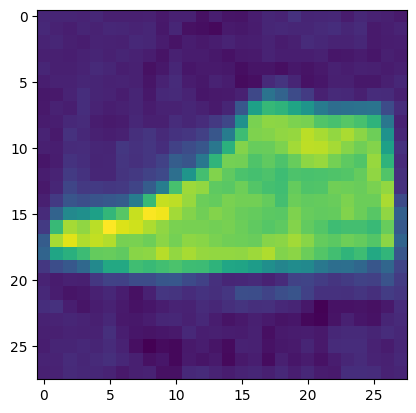

In [106]:
vaeModel.eval()
output = vaeModel.decoder(z0)
plt.imshow(output.cpu().detach().numpy().reshape(28,28))